In [1]:
import numpy as np
import spectrumtools as spt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"]=(7,4)

# Notes

Select a file and plot the spectrum.

data input from  C:/Users/USER/Documents/research/linax/datastore/Pb208/pb208gdr.dat


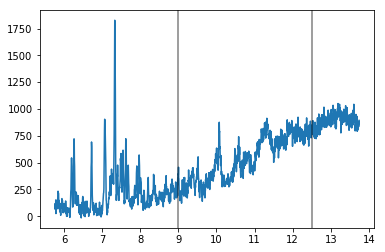

In [2]:
nucleus="208Pb"
xnucleus=nucleus[3:]+nucleus[0:3]  # fiddle name and A !
path=spt.findstore(xnucleus)

angle=0.4
lump=1
targetfilename="pb208gdr.dat"
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800
        
ROIlo=ROIlo+50
ROIhi=ROIhi+50

ROIlo=550
ROIhi=2150
        
# *** Read in data
try:
    print("data input from ",path+targetfilename)
    e,cs0=np.loadtxt(path+targetfilename,unpack=True,usecols=(0,1))
    de=e[2]-e[1]
    # energy in MeV: find kev/ch as int
    intde=int(de*1000.0+0.1)
    G=cs0
    X=e
except:
    raise(ValueError,("File not found"))

plt.plot(e[ROIlo:ROIhi],cs0[ROIlo:ROIhi])
plt.axvline(9.0,color='k',alpha=0.5)
plt.axvline(12.5,color='k',alpha=0.5)
elo=e[ROIlo]
ehi=e[ROIhi]

Peaks in range 6..9 MeV  are mainly 1- (see Poltarotska thesis)

Create container objects for the ratio spectra and the analysis bins.

Plot the stationary spectrum in ROI.

sig=0.0170  sigsm= 0.0596 sigsmn= 0.0160 MeV


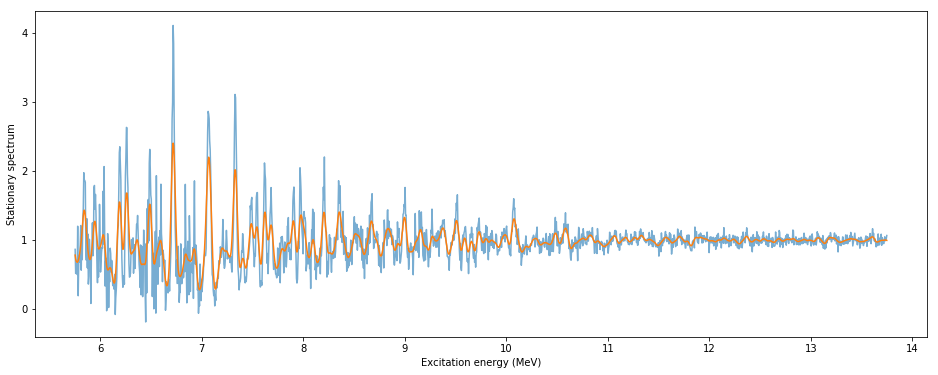

In [41]:
sig = 40.0/2.35/1000.0 # 50 best, at least up to 10 MeV; but Iryna gives 25-30 ??
# 4/5/2018: peakfit to peaks between 5.8 and 8.8 MeV gives fwhm=32.7 keV
#sig = 32.7/2.35/1000.0 # 50 best, at least up to 10 MeV; but Iryna gives 25-30 ??
#sig = 20.0/2.35/1000.0 # 50 best, at least up to 10 MeV; but Iryna gives 25-30 ??
sigsm=3.5*sig
sigsmn=0.4*2.35*sig #was 0.39
sigx=sigsm*2.5
print("sig=%6.4f  sigsm=%7.4f sigsmn=%7.4f MeV"%(sig,sigsm,sigsmn))

S=spt.RatioSpectrum( X, G, targetfilename, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

plt.figure(figsize=(16,6))
plt.plot(Eratio, ratioraw, alpha=0.6)
plt.plot(Eratio, rationar)
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Stationary spectrum")
plt.show()

In [42]:
bins=spt.ACBinner(S,NAC=8,Nslides=1)
print("Computed bin limits:\n",bins.get_bins())

Computed bin limits:
 [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, 1600)]


Now plot the raw and smoothed spectra in the ROI.

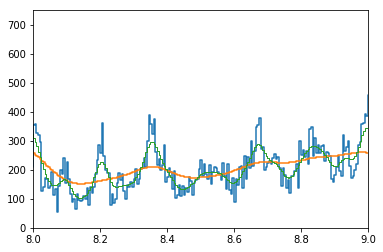

In [43]:
plt.xlim(8.0,9.0)
plt.ylim(0.0,750.0)
plt.plot(S.Eratio,S.gROI,drawstyle='steps-mid')
plt.plot(S.Eratio,S.gROIw,drawstyle='steps-mid')
plt.plot(S.Eratio,S.gROIn,lw=1.0,drawstyle='steps-mid')

Select a dataset to show a typical autocorrelation analysis.

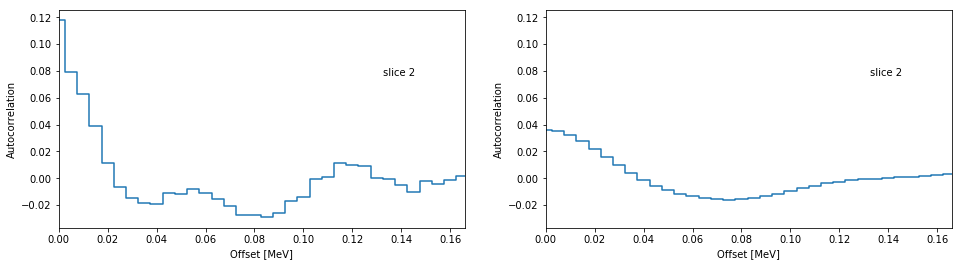

In [44]:
binlist=bins.get_bins()
index=2
l,h=binlist[index]
#print("Bin limits: %8.3f .. %8.3f MeV"%bins.get_bin_limits(index))
bin=spt.Bin(bins.data,l,l+(h-l)//2)
bin=spt.Bin(bins.data,l,h)
energy=bin.Eoffset
data=bin.acnar
plt.figure(figsize=(16,4))
plt.subplot(121)
#plt.plot(energy, data, drawstyle='steps-mid')
plt.plot(energy,bin.acraw, drawstyle='steps-mid')
yl,yh=plt.ylim()
plt.xlim(0.0,energy[-1]/6)
plt.text(0.8,0.7,"slice %d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.subplot(122)
plt.plot(energy, data, drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/6)
plt.text(0.8,0.7,"slice %d"%index,transform=plt.gca().transAxes)
plt.xlabel("Offset [MeV]")
plt.ylabel("Autocorrelation")
plt.ylim(yl,yh)
plt.show()

(0.0, 0.2487499999999998)

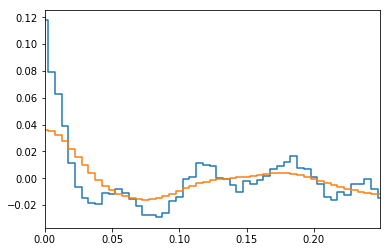

In [45]:
plt.plot(energy,bin.acraw,drawstyle='steps-mid')
plt.plot(energy, data,drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)


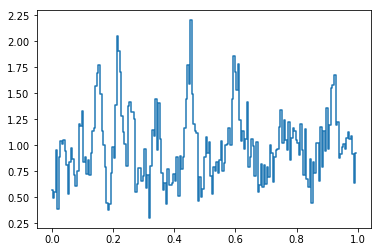

In [46]:
plt.plot(energy,bin.dataraw,drawstyle='steps-mid')

Now set up for fits

In [47]:
import lmfit

def ACtheory(x, sign, sigw, alpha, D):
    """
    'Hansen' autocorrelation formula for spectrum
    x: energy offset (MeV)
    sign: narrow smooth or sigexpt, >= sigexpt
    sigw: wide smooth
    alpha: variance parameter
    D: level spacing
    11/7/2012: fix 4->2 in last term
    """
    sigtsq=sign**2+sigw**2
    A=(alpha*D)/(2.0*np.sqrt(np.pi))
    act=A*( np.exp(-x*x/(4.*sign*sign))/sign+
            np.exp(-x*x/(4.*sigw*sigw))/sigw-
            np.sqrt(8./sigtsq)*np.exp(-x*x/(2.*sigtsq))
            )
    return act

def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))
    return (model-data)/unc

def model(params, e):
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    #ys=sigw/sign
    #ysp=1.+ys*ys
    #sig=sign
    #model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    #model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    #model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return ACtheory(e, sign, sigw, alpha, D)

alpha=2.273
initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
ndata=len(data)
params=lmfit.Parameters()
params.add('D',value=1.0, min=0.0)
params.add('sign',value=np.sqrt(sig**2+sigsmn**2),min=0.0,vary=False)
params.add('sigw',value=np.sqrt(sigsm**2+sig**2),min=0.0,vary=False)
params.add('sigx',value=sigx,vary=False)
theoreticalmodel=model(params,0.0)
params['D'].set(value=initialD)
noise=bin.get_noise_correction(sigsmn, sigsm)
#uncert=np.linspace(data[0]/10,data[0]/5,ndata)
uncert=np.ones(len(data))*data[1]/10.0
ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
#initial=1.0
#popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
#sig=popt[1]
#popt[0]*=initialD
minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                       fcn_kws={'unc':uncert})
result=minner.minimize()
lmfit.printfuncs.report_fit(result.params)

p=result.params.valuesdict()
rho=1.0/p['D']
elo,ehi=bins.get_bin_limits(index)
en=(elo+ehi)/2
print(en,rho,1.0/initialD,p['sigw'],p['sign'],p['sigx'])
D0=ACfx[0]/theoreticalmodel
print(D0,1./D0,ACfx[0],theoreticalmodel)

[[Variables]]
    D:     0.00312993 +/- 3.4136e-05 (1.09%) (init = 0.000960365)
    sign:  0.02336073 (fixed)
    sigw:  0.06195838 (fixed)
    sigx:  0.1489362 (fixed)
8.25 319.4962679210704 1041.2707563245117 0.06195838203642995 0.023360733227979928 0.14893617021276595
0.0033022144963439164 302.82708803657704 0.03436856614135747 10.407732804579778


!!! sign held fixed in fit !!!


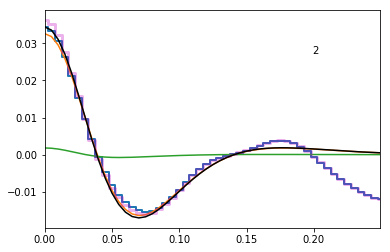

In [48]:
m=model(result.params, energy)
plt.plot(energy, data-noise,lw=2,drawstyle='steps-mid')
plt.xlim(0.0,energy[-1]/4)
plt.text(0.8,0.8,"%d"%index,transform=plt.gca().transAxes)
plt.plot(energy,m)
plt.plot(energy,noise)
plt.plot(energy,data,'m-',lw=3.0,drawstyle='steps-mid',alpha=0.3)
#plt.plot(energy,ACfx,'c-',lw=3.0,drawstyle='steps-mid',alpha=0.3)
plt.plot(energy,m+noise,'k-')
if params['sign'].vary is False:
    print("!!! sign held fixed in fit !!!")

Now use MCMC to generate the Bayesian posterior probability distribution. Plot the corner plot.

In [55]:
# def function to be used in MC uncertainty analysis (the log likelihood)
def loglike(param, f, data, unc=None):
    #noise=param['noise']
    return -0.5*(np.sum(fitforlm(param,f,data,unc)**2)+np.log(2.0*np.pi*np.sum(unc*unc)))

MC=False

# MC for parameters: use the log likelihood function.
if MC:
    mcmin = lmfit.Minimizer(loglike, minner.params, fcn_args=(energy, data*np.exp(-energy**2/(2.0*sigx**2))),fcn_kws={'unc':uncert})
    res = mcmin.emcee(burn=300, steps=1000, thin=10, params=minner.params, is_weighted=True)
    print("done") # takes a while, needs some feedback.

In [56]:
import corner
if MC:
    figure=corner.corner(res.flatchain, bins=20, quantiles=(0.16,0.84), 
                     labels=res.var_names, truths=list(res.params.valuesdict().values()))

Get the confidence limits from the above distribution.

In [51]:
quantiles=np.percentile(res.flatchain['D'], [2.28, 97.7])
print("uncertainty: index=",index, "rho=",1.0/quantiles[1],"..",1.0/quantiles[0])

uncertainty: index= 2 rho= 280.88635452932806 .. 333.81777093168034


Now analyse the full set of autocorrelation data.

Note: take-home point: strong correlation (~1.0) between D and sign

In [52]:
rholist=[]
#print(theoreticalmodel)
#print(1.0/((2.0*np.sqrt(np.pi)*sig)/alpha))
for i,(l,h) in enumerate(binlist):
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    #params.add('sign',value=sig,min=0.0, vary=False)
    #params.add('sigw',value=sigsm,min=0.0,vary=False)
    params.add('sign',value=np.sqrt(sig**2+sigsmn**2),min=0.0,vary=False)
    params.add('sigw',value=np.sqrt(sigsm**2+sig**2),min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    noise=bin.get_noise_correction(sigsmn, sigsm)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx),
                           fcn_kws={'unc':uncert})
    result=minner.minimize()
    D0=ACfx[0]/theoreticalmodel
    D0=data[0]/theoreticalmodel
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    rhofit=1.0/p['D']
    rho=1.0/D0    # < ========
    elo,ehi=bins.get_bin_limits(i)
    en=(elo+ehi)/2
    print(i, D0, initialD, p['D'], rho, rhofit)
    print(ACfx[0])
    rholist.append((en,rho,rhofit))

[[Variables]]
    D:     0.01214289 +/- 3.6646e-04 (3.02%) (init = 0.004225622)
    sign:  0.02336073 (fixed)
    sigw:  0.06195838 (fixed)
    sigx:  0.1489362 (fixed)
0 0.01529455755013527 0.004225622316422272 0.012142890878929169 65.38273478798057 82.3527123788323
0.15252028085765287
[[Variables]]
    D:     0.01795353 +/- 2.7426e-04 (1.53%) (init = 0.005385598)
    sign:  0.02336073 (fixed)
    sigw:  0.06195838 (fixed)
    sigx:  0.1489362 (fixed)
1 0.01949306535635457 0.0053855975705921115 0.0179535343563193 51.300294834029714 55.6993392027024
0.19956025564734486
[[Variables]]
    D:     0.00313923 +/- 2.9041e-05 (0.93%) (init = 0.000960365)
    sign:  0.02336073 (fixed)
    sigw:  0.06195838 (fixed)
    sigx:  0.1489362 (fixed)
2 0.0034760224199260055 0.0009603650097020015 0.003139232501816913 287.6851410012733 318.5491993413115
0.03436856614135747
[[Variables]]
    D:     0.00134134 +/- 3.1861e-05 (2.38%) (init = 0.0004279198)
    sign:  0.02336073 (fixed)
    sigw:  0.06195838

In [53]:
rholist=np.array( rholist )
print(np.shape(rholist))

(8, 3)


Plot the calculated level densities.

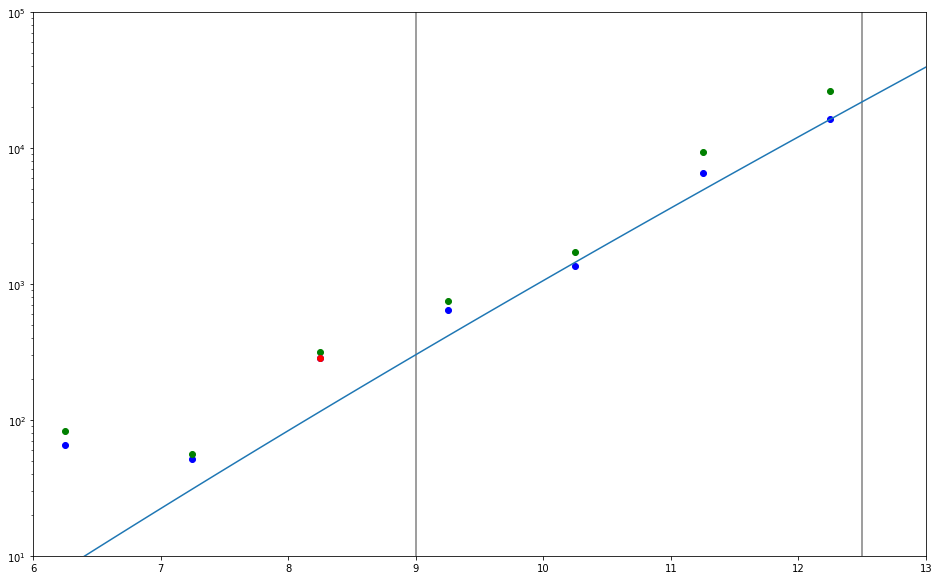

In [54]:
import leveldensities as ldn
e=rholist.T[0]
rho=rholist.T[1]
rhofit=rholist.T[2]
plt.figure(figsize=(16,10))
plt.semilogy(e,rho,'bo')
plt.semilogy(e,rhofit,'go')
plt.semilogy(e[index],rho[index],'ro')
plt.xlim(6.0,13.0)
plt.ylim(1e1,1e5)
#Iryna data on line 9..12.5 MeV
plt.axvline(9.0,color='k',alpha=0.5)
plt.axvline(12.5,color='k',alpha=0.5)
# theory
Eth=np.linspace(5.0,13.0)
Z,N=82,208-82
Spin=1.0
rhoth=ldn.LevelDenRauscher(Eth, Z, N, Spin)
plt.plot(Eth,rhoth)